## Set-up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import plotly.express as px
import random

from glob import glob
import cv2
from pathlib import Path
import os
from sklearn.metrics import classification_report

In [2]:
train_df = pd.read_csv('/projects/sc73/ranzcr-clip-catheter-line-classification/train.csv')
train_annot = pd.read_csv('/projects/sc73/ranzcr-clip-catheter-line-classification/train_annotations.csv')

In [3]:
from pathlib import Path

path = Path('/projects/sc73/ranzcr-clip-catheter-line-classification/train')

def add_path(row):

    row['image_path'] = str(path / (row['StudyInstanceUID'] + '.jpg'))
    return row

train_df = train_df.apply(add_path, axis=1)

## Pre-processing

In [4]:
# creates a function that displays one or more images
def display_image(paths):
  if type(paths) == str:
    image = cv2.imread(paths)
    plt.imshow(image)
    plt.figsize=(4,4)
    plt.show()

  elif type(paths) == pd.Series:
    paths = paths.tolist()

    image = []
    for path in paths:
      image.append(cv2.imread(path))

    fig, ax = plt.subplots(len(paths),1, figsize=(4,4))
    for i in range(len(paths)):
      ax[i].imshow(image[i])

    plt.tight_layout()
    plt.show()

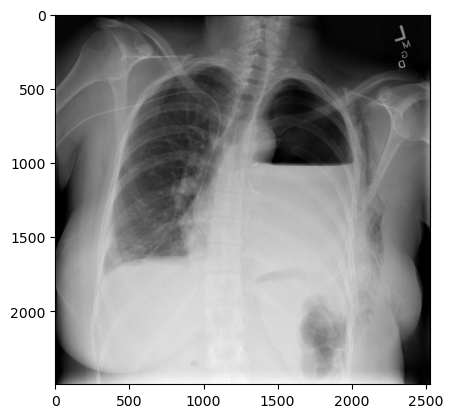

In [5]:
display_image(train_df['image_path'][2])

In [6]:
def save_overlay_annot(StudyInstanceUID):
  cmap = {'CVC - Normal':'mediumslateblue',
          'CVC - Borderline':'deeppink',
          'NGT - Normal':'greenyellow',
          'ETT - Normal':'lightseagreen',
          'CVC - Abnormal':'lawngreen',
          'ETT - Borderline':'orange',
          'Swan Ganz Catheter Present':'indianred',
          'NGT - Borderline':'yellow',
          'NGT - Abnormal':'deepskyblue',
          'ETT - Abnormal':'aquamarine',
          'NGT - Incompletely Imaged':'purple'}

  annot = train_annot[train_annot['StudyInstanceUID'] == StudyInstanceUID]
  image = cv2.imread(train_df[train_df['StudyInstanceUID'] == StudyInstanceUID]['image_path'].values[0])
  height, width, _ = image.shape
  dpi=100
  plt.figure(figsize=(width/dpi, height/dpi), dpi=dpi)

  labels_added = set()

  for i in range(len(annot)):
    points = np.array(ast.literal_eval(annot.iloc[i]['data']))
    x = points[:, 0]
    y = points[:, 1]
    label = annot.iloc[i]['label']

    plt.plot(x, y, color=cmap[annot.iloc[i]["label"]], linestyle='-')

  plt.imshow(image)
  plt.axis('off')
  plt.savefig(f'/fs03/sc73/Shekinah Robins/train_imgs/{StudyInstanceUID}.jpg', bbox_inches='tight', pad_inches=0)
  plt.close()

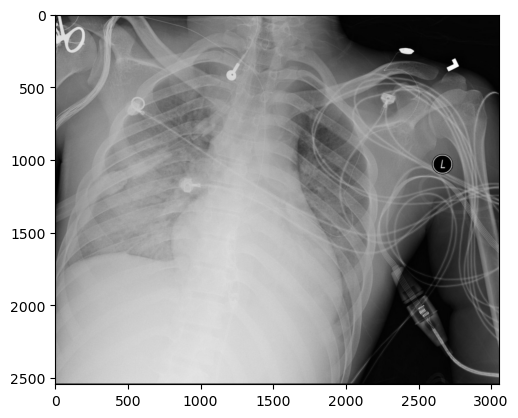

In [7]:
columns_to_check = [
    'ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal',
    'NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged',
    'NGT - Normal', 'CVC - Abnormal', 'CVC - Borderline',
    'CVC - Normal', 'Swan Ganz Catheter Present'
]

train_df_all_zeros = train_df[train_df[columns_to_check].eq(0).all(axis=1)].reset_index(drop=True)

display_image(train_df_all_zeros['image_path'][2])

In [8]:
train_df = train_df[~train_df[columns_to_check].eq(0).all(axis=1)].reset_index(drop=True)

train_df = train_df[train_df['NGT - Incompletely Imaged'] == 0]
train_df = train_df.drop(columns=['NGT - Incompletely Imaged'])

train_df = train_df[train_df['Swan Ganz Catheter Present'] == 0]
train_df = train_df.drop(columns=['Swan Ganz Catheter Present'])
train_df.shape

(26752, 12)

In [9]:
ids =  train_annot['StudyInstanceUID'].unique()

In [10]:
train_df_annot = train_df[train_df['StudyInstanceUID'].isin(ids)]
train_df_annot

def update_path(row):
    row['image_path'] = f'/fs03/sc73/Shekinah Robins/train_imgs/{row["StudyInstanceUID"]}.jpg'
    return row

train_df_annot = train_df_annot.apply(update_path, axis=1).reset_index(drop=True)

In [11]:
train_df_annot.shape

(7971, 12)

## Model Pre-Processing

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, EfficientNetB0, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import resample

2024-10-14 21:50:58.641835: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-14 21:50:58.711192: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [13]:
tube_classifying= train_df_annot.copy()

In [14]:
tube_classifying['CVC - Borderline'].value_counts()

CVC - Borderline
0    5648
1    2323
Name: count, dtype: int64

In [15]:
tube_classifying['CVC - Abnormal'].value_counts()

CVC - Abnormal
0    6939
1    1032
Name: count, dtype: int64

In [16]:
tube_classifying['CVC - Normal'].value_counts()

CVC - Normal
1    5540
0    2431
Name: count, dtype: int64

In [17]:
tube_classifying['CVC_placement'] = tube_classifying[['CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal']].values.tolist()

counts = tube_classifying['CVC_placement'].value_counts()
counts_df = counts.reset_index()
counts_df.columns = ['CVC_placement', 'Count']  


counts_df['CVC_Placements'] = counts_df['CVC_placement'].apply(
    lambda x: f'CVC Abnormal: {x[0]}, CVC Borderline: {x[1]}, CVC Normal: {x[2]}'
)

print(counts_df[['CVC_Placements', 'Count']])

                                      CVC_Placements  Count
0  CVC Abnormal: 0, CVC Borderline: 0, CVC Normal: 1   4575
1  CVC Abnormal: 0, CVC Borderline: 1, CVC Normal: 0   1464
2  CVC Abnormal: 0, CVC Borderline: 1, CVC Normal: 1    735
3  CVC Abnormal: 1, CVC Borderline: 0, CVC Normal: 0    699
4  CVC Abnormal: 1, CVC Borderline: 0, CVC Normal: 1    209
5  CVC Abnormal: 0, CVC Borderline: 0, CVC Normal: 0    165
6  CVC Abnormal: 1, CVC Borderline: 1, CVC Normal: 0    103
7  CVC Abnormal: 1, CVC Borderline: 1, CVC Normal: 1     21


In [18]:
ct_id = tube_classifying['StudyInstanceUID'].unique()
test_data = train_df[~train_df['StudyInstanceUID'].isin(ct_id)].copy() 
test_data['CVC_placement'] = test_data[['CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal']].values.tolist()

In [19]:
test_data = test_data.sample(5000)

In [20]:
counts = test_data['CVC_placement'].value_counts()
counts_df = counts.reset_index()
counts_df.columns = ['CVC_placement', 'Count']  


counts_df['CVC_Placements'] = counts_df['CVC_placement'].apply(
    lambda x: f'CVC Abnormal: {x[0]}, CVC Borderline: {x[1]}, CVC Normal: {x[2]}'
)

print(counts_df[['CVC_Placements', 'Count']])

                                      CVC_Placements  Count
0  CVC Abnormal: 0, CVC Borderline: 0, CVC Normal: 1   3086
1  CVC Abnormal: 0, CVC Borderline: 1, CVC Normal: 0    957
2  CVC Abnormal: 1, CVC Borderline: 0, CVC Normal: 0    374
3  CVC Abnormal: 0, CVC Borderline: 1, CVC Normal: 1    339
4  CVC Abnormal: 0, CVC Borderline: 0, CVC Normal: 0    102
5  CVC Abnormal: 1, CVC Borderline: 0, CVC Normal: 1     94
6  CVC Abnormal: 1, CVC Borderline: 1, CVC Normal: 0     41
7  CVC Abnormal: 1, CVC Borderline: 1, CVC Normal: 1      7


## Tube Classification Models

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder

In [31]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, x_col, y_col, transform=None):
        self.dataframe = dataframe
        self.x_col = x_col
        self.y_col = y_col
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx][self.x_col]
        image = Image.open(img_path).convert('RGB')  
        label = [float(x) for x in self.dataframe.iloc[idx][self.y_col]] 

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

In [23]:
class ResNet50Multilabel(nn.Module):
    def __init__(self, num_classes=3, freeze_layers=True):
        super(ResNet50Multilabel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
            
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.3),          # Dropout layer for regularization
            nn.Linear(in_features, 256),  # First hidden layer
            nn.ReLU(),                # ReLU activation after first hidden layer
            nn.Dropout(0.3),          # Additional Dropout layer
            nn.Linear(256, num_classes)  # Output layer
        )

    def forward(self, x):
        return torch.sigmoid(self.resnet(x))  # Sigmoid on the final output

In [24]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, 
                checkpoint_path="res_CVC2.pth", patience=5, min_delta=0.001):
    history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    best_model_state_dict = None

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

            # Update prediction logic for multilabel
            predicted = (outputs > 0.5).float()  # Convert to binary
            train_correct += (predicted == labels).sum().item()
            train_total += labels.numel()  # Total number of elements

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total
        history['accuracy'].append(train_acc)
        history['loss'].append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).float()
                val_correct += (predicted == labels).sum().item()
                val_total += labels.numel()

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        history['val_accuracy'].append(val_acc)
        history['val_loss'].append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Save the best model
        if val_acc - best_val_accuracy > min_delta:
            best_val_accuracy = val_acc
            best_model_state_dict = model.state_dict()
            epochs_no_improve = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_accuracy': val_acc,
            }, checkpoint_path)
            print(f"Checkpoint saved with validation accuracy: {val_acc:.4f}")
        else:
            epochs_no_improve += 1

        # Early stopping
        if epochs_no_improve == patience:
            print(f"Early stopping triggered. No improvement for {patience} epochs.")
            break

    if best_model_state_dict is not None:
        model.load_state_dict(best_model_state_dict)
        print("Restored best model weights")

    return history, model

In [25]:
def visualize_training(history, image_type, save_path):
    acc_min = min(min(history['accuracy']), min(history['val_accuracy'])) - 0.005
    acc_max = max(max(history['accuracy']), max(history['val_accuracy'])) + 0.005
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(history['accuracy'], label='Training Accuracy', color='palevioletred')
    plt.plot(history['val_accuracy'], label='Validation Accuracy', color='cornflowerblue')
    plt.ylim([acc_min, acc_max]) 
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid()
    plt.title(f'Training and Validation Accuracy - ResNet50 {image_type}', fontweight='bold')
    
    loss_min = min(min(history['loss']), min(history['val_loss'])) - 0.005
    loss_max = max(max(history['loss']), max(history['val_loss'])) + 0.005
    
    plt.subplot(2, 1, 2)
    plt.plot(history['loss'], label='Training Loss', color='palevioletred')
    plt.plot(history['val_loss'], label='Validation Loss', color='cornflowerblue')
    plt.ylim([loss_min, loss_max])
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.title(f'Training and Validation Loss - ResNet50 {image_type}', fontweight='bold')
    plt.grid()
    plt.xlabel('epoch')

    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [26]:
def evaluate_model(model, test_loader, device, class_names, image_type):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()  # Apply threshold for multi-label

            y_true.append(labels.cpu().numpy())
            y_pred.append(predicted.cpu().numpy())

    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)

    # Calculate confusion matrix for each class
    for i, class_name in enumerate(class_names):
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])
        
        plt.figure(figsize=(4, 4))
        sns.heatmap(cm, annot=True, fmt='g', cmap='BuPu', cbar=False,
                    xticklabels=[0, 1],
                    yticklabels=[0, 1])
        plt.title(f'ResNet50 {image_type} Confusion Matrix for {class_name}')
        plt.xlabel('Predicted Label', fontweight='bold')
        plt.ylabel('True Label', fontweight='bold')
        plt.savefig(f'conf_matrix_res_cvc_place_{class_name}.png', dpi=300, bbox_inches='tight')
        plt.close()

    report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
    print("Classification Report:")
    print(report)

    with open(f'classification_res_cvc_place.txt', 'w') as f:
        f.write(report)

    return y_true, y_pred

In [34]:
def main_placement(train_df_annot, test_data):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                             std=[0.229, 0.224, 0.225])  
    ])
    
    val_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])   
    ])

    # Create the dataset
    full_dataset = CustomDataset(train_df_annot, 'image_path', 'CVC_placement', transform=train_transform)

    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    test_dataset = CustomDataset(test_data, 'image_path', 'CVC_placement', transform=val_test_transform)

    val_dataset.dataset.transform = val_test_transform

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Initialize model, criterion, and optimizer
    model = ResNet50Multilabel(num_classes=len(['Abnormal', 'Borderline', 'Normal'])).to(device)  
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    history, model = train_model(model, train_loader, val_loader, criterion, optimizer, device,
                                 num_epochs=10, checkpoint_path=f"res_cvc_place_model.pth")

    # Visualize training history
    visualize_training(history, 'CVC_placement', f'training_curve_res_cvc_place.png')

    # Evaluate the model
    evaluate_model(model, test_loader, device, class_names=['Abnormal', 'Borderline', 'Normal'], image_type='CVC_placement')


#### Classifying CVC Placement - ResNet50

/apps/miniforge3/24.3.0-0/miniforge3/envs/dsks_2024.06/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/apps/miniforge3/24.3.0-0/miniforge3/envs/dsks_2024.06/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/clai0032/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 87.0MB/s]


Epoch 1/10:
Train Loss: 0.0693, Train Acc: 0.9790
Val Loss: 0.0357, Val Acc: 0.9934
Checkpoint saved with validation accuracy: 0.9934
Epoch 2/10:
Train Loss: 0.0257, Train Acc: 0.9935
Val Loss: 0.9550, Val Acc: 0.8228
Epoch 3/10:
Train Loss: 0.0257, Train Acc: 0.9932
Val Loss: 0.0094, Val Acc: 0.9983
Checkpoint saved with validation accuracy: 0.9983
Epoch 4/10:
Train Loss: 0.0206, Train Acc: 0.9945
Val Loss: 0.0092, Val Acc: 0.9976
Epoch 5/10:
Train Loss: 0.0263, Train Acc: 0.9928
Val Loss: 0.0116, Val Acc: 0.9979
Epoch 6/10:
Train Loss: 0.0116, Train Acc: 0.9971
Val Loss: 0.0041, Val Acc: 0.9993
Epoch 7/10:
Train Loss: 0.0084, Train Acc: 0.9980
Val Loss: 0.0036, Val Acc: 0.9984
Epoch 8/10:
Train Loss: 0.0136, Train Acc: 0.9965
Val Loss: 0.0304, Val Acc: 0.9917
Early stopping triggered. No improvement for 5 epochs.
Restored best model weights


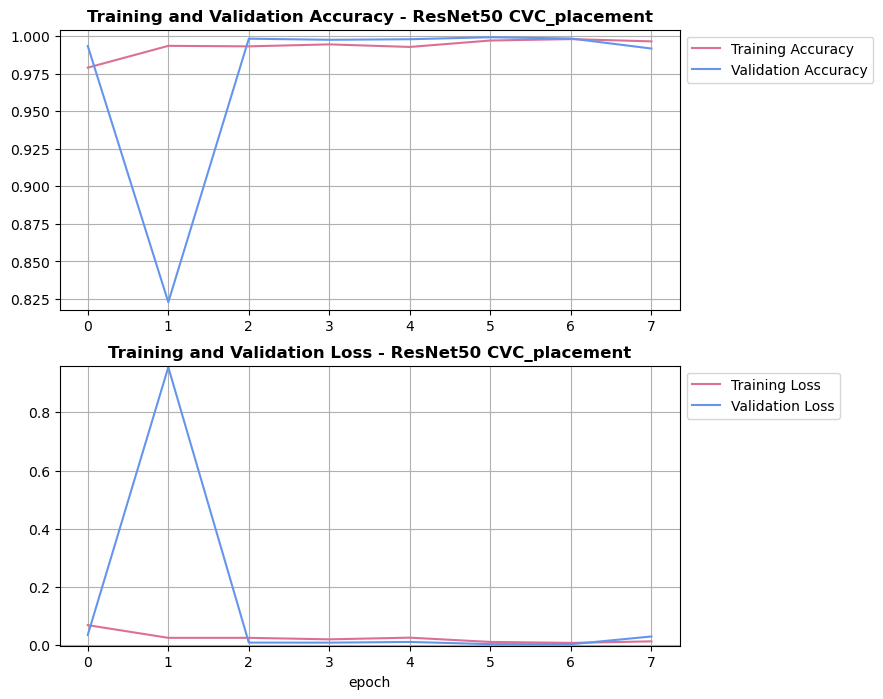

Classification Report:
              precision    recall  f1-score   support

    Abnormal       0.00      0.00      0.00       493
  Borderline       0.00      0.00      0.00      1394
      Normal       0.00      0.00      0.00      3453

   micro avg       0.00      0.00      0.00      5340
   macro avg       0.00      0.00      0.00      5340
weighted avg       0.00      0.00      0.00      5340
 samples avg       0.00      0.00      0.00      5340



In [36]:
if __name__ == "__main__":
    # Specify the image type you want to train on
    tube_type = "CVC"  # Change this to train on different image types (CVC, ETT, or NGT)

    majority = tube_classifying[tube_classifying[f'{tube_type}_placement'].apply(lambda x: x == [0, 0, 1])]
    minority = tube_classifying[tube_classifying[f'{tube_type}_placement'].apply(lambda x: x != [0, 0, 1])]

    minority_upsampled = resample(minority, 
                                   replace=True,    
                                   n_samples=len(majority)*2,  
                                   random_state=42)

    upsampled = pd.concat([majority, minority_upsampled])
    upsampled = upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

    try:
        main_placement(upsampled, test_data)
    except Exception as e:
        print(f"An error occurred during execution: {str(e)}")
        raise

#### Classifying ETT Placement - ResNet50

/apps/miniforge3/24.3.0-0/miniforge3/envs/dsks_2024.06/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/apps/miniforge3/24.3.0-0/miniforge3/envs/dsks_2024.06/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10:
Train Loss: 0.1020, Train Acc: 0.9646
Val Loss: 0.0500, Val Acc: 0.9871
Checkpoint saved with validation accuracy: 0.9871
Epoch 2/10:
Train Loss: 0.0401, Train Acc: 0.9894
Val Loss: 0.0368, Val Acc: 0.9913
Checkpoint saved with validation accuracy: 0.9913
Epoch 3/10:
Train Loss: 0.0362, Train Acc: 0.9907
Val Loss: 0.0193, Val Acc: 0.9948
Checkpoint saved with validation accuracy: 0.9948
Epoch 4/10:
Train Loss: 0.0261, Train Acc: 0.9933
Val Loss: 0.0659, Val Acc: 0.9812
Epoch 5/10:
Train Loss: 0.0295, Train Acc: 0.9923
Val Loss: 0.0190, Val Acc: 0.9951
Epoch 6/10:
Train Loss: 0.0200, Train Acc: 0.9943
Val Loss: 0.0097, Val Acc: 0.9981
Checkpoint saved with validation accuracy: 0.9981
Epoch 7/10:
Train Loss: 0.0186, Train Acc: 0.9954
Val Loss: 0.0113, Val Acc: 0.9981
Epoch 8/10:
Train Loss: 0.0155, Train Acc: 0.9962
Val Loss: 0.0133, Val Acc: 0.9984
Epoch 9/10:
Train Loss: 0.0195, Train Acc: 0.9947
Val Loss: 0.0228, Val Acc: 0.9945
Epoch 10/10:
Train Loss: 0.0191, Train Acc: 

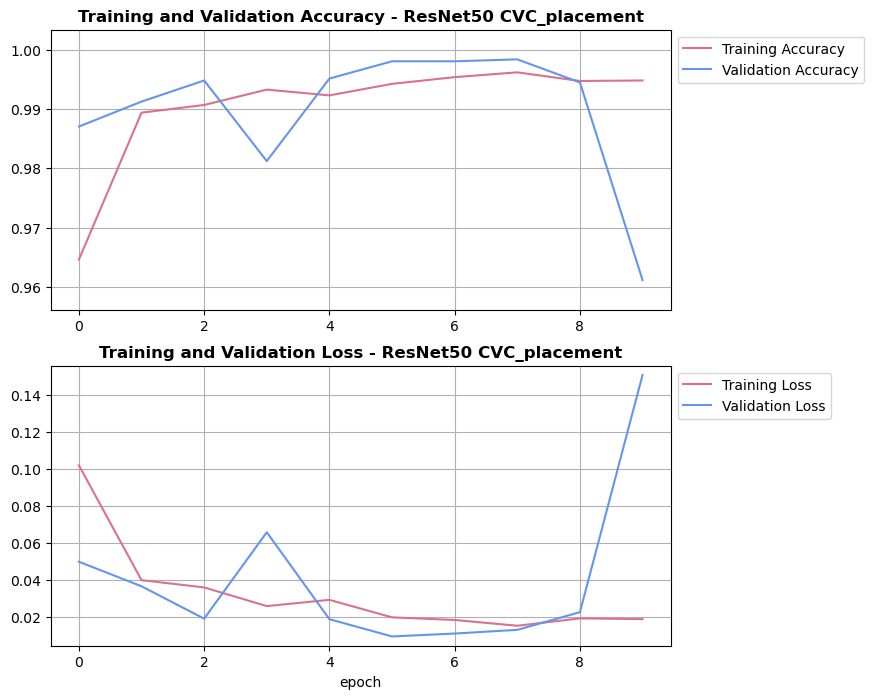

Classification Report:
              precision    recall  f1-score   support

    Abnormal       0.00      0.00      0.00       493
  Borderline       0.00      0.00      0.00      1394
      Normal       0.66      0.02      0.04      3453

   micro avg       0.66      0.01      0.03      5340
   macro avg       0.22      0.01      0.01      5340
weighted avg       0.43      0.01      0.03      5340
 samples avg       0.02      0.02      0.02      5340



In [39]:
if __name__ == "__main__":
    # Specify the image type you want to train on
    tube_type = "ETT"  # Change this to train on different image types (CVC, ETT, or NGT)

    tube_classifying[f'{tube_type}_placement'] = tube_classifying[[f'{tube_type} - Abnormal', f'{tube_type} - Borderline', f'{tube_type} - Normal']].values.tolist()

    majority = tube_classifying[tube_classifying[f'{tube_type}_placement'].apply(lambda x: x == [0, 0, 1])]
    minority = tube_classifying[tube_classifying[f'{tube_type}_placement'].apply(lambda x: x != [0, 0, 1])]

    minority_upsampled = resample(minority, 
                                   replace=True,    
                                   n_samples=len(majority)*2,  
                                   random_state=42)

    upsampled = pd.concat([majority, minority_upsampled])
    upsampled = upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

    try:
        main_placement(upsampled, test_data)
    except Exception as e:
        print(f"An error occurred during execution: {str(e)}")
        raise

#### Classifying NGT Placement - ResNet50

/apps/miniforge3/24.3.0-0/miniforge3/envs/dsks_2024.06/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/apps/miniforge3/24.3.0-0/miniforge3/envs/dsks_2024.06/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10:
Train Loss: 0.0977, Train Acc: 0.9663
Val Loss: 0.0217, Val Acc: 0.9947
Checkpoint saved with validation accuracy: 0.9947
Epoch 2/10:
Train Loss: 0.0498, Train Acc: 0.9873
Val Loss: 0.0430, Val Acc: 0.9897
Epoch 3/10:
Train Loss: 0.0238, Train Acc: 0.9933
Val Loss: 0.0209, Val Acc: 0.9953
Epoch 4/10:
Train Loss: 0.0311, Train Acc: 0.9923
Val Loss: 0.0147, Val Acc: 0.9972
Checkpoint saved with validation accuracy: 0.9972
Epoch 5/10:
Train Loss: 0.0127, Train Acc: 0.9969
Val Loss: 0.0110, Val Acc: 0.9988
Checkpoint saved with validation accuracy: 0.9988
Epoch 6/10:
Train Loss: 0.0244, Train Acc: 0.9943
Val Loss: 0.0400, Val Acc: 0.9897
Epoch 7/10:
Train Loss: 0.0290, Train Acc: 0.9919
Val Loss: 0.0213, Val Acc: 0.9953
Epoch 8/10:
Train Loss: 0.0182, Train Acc: 0.9955
Val Loss: 0.0155, Val Acc: 0.9969
Epoch 9/10:
Train Loss: 0.0093, Train Acc: 0.9975
Val Loss: 0.0190, Val Acc: 0.9969
Epoch 10/10:
Train Loss: 0.0165, Train Acc: 0.9955
Val Loss: 0.0195, Val Acc: 0.9972
Early sto

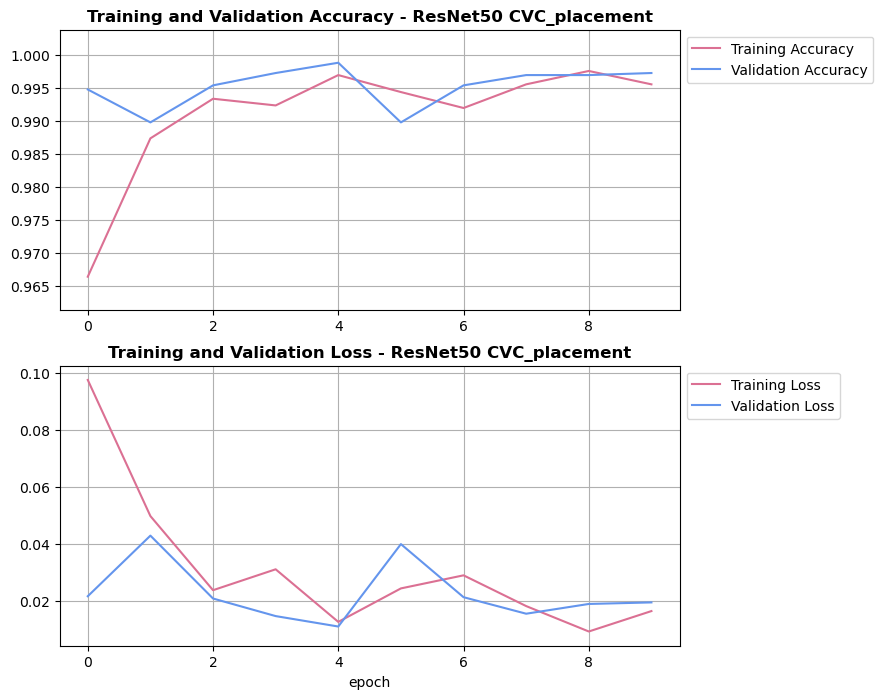

Classification Report:
              precision    recall  f1-score   support

    Abnormal       0.00      0.00      0.00       493
  Borderline       0.00      0.00      0.00      1394
      Normal       0.00      0.00      0.00      3453

   micro avg       0.00      0.00      0.00      5340
   macro avg       0.00      0.00      0.00      5340
weighted avg       0.00      0.00      0.00      5340
 samples avg       0.00      0.00      0.00      5340



In [40]:
if __name__ == "__main__":
    # Specify the image type you want to train on
    tube_type = "NGT"  # Change this to train on different image types (CVC, ETT, or NGT)

    tube_classifying[f'{tube_type}_placement'] = tube_classifying[[f'{tube_type} - Abnormal', f'{tube_type} - Borderline', f'{tube_type} - Normal']].values.tolist()

    majority = tube_classifying[tube_classifying[f'{tube_type}_placement'].apply(lambda x: x == [0, 0, 1])]
    minority = tube_classifying[tube_classifying[f'{tube_type}_placement'].apply(lambda x: x != [0, 0, 1])]

    minority_upsampled = resample(minority, 
                                   replace=True,    
                                   n_samples=len(majority)*2,  
                                   random_state=42)

    upsampled = pd.concat([majority, minority_upsampled])
    upsampled = upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

    try:
        main_placement(upsampled, test_data)
    except Exception as e:
        print(f"An error occurred during execution: {str(e)}")
        raise